In [46]:
import json
import os
import pandas as pd
from datetime import timedelta
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

## Google fit 

Issue: timestamps are sorted by time not date so the association between progressive session number and the table is wrong. I've applied date and time separation in order to sort by date ("merging and rearranging section") but I think it should be done by the beginning so also the rest of the code shuould be adapted accordingly.

In [50]:
data_dir = os.getcwd()+'/data/martina/'

In [51]:
def step_counts():
    
    # import data
    with open(data_dir + 'derived_com.google.step_count.delta_com.google(2).json') as file:
        steps = json.load(file)
        data = steps['Data Points']
        steps_dict = {}
    
    # convert time nanos to datetime
    for index in range(0,len(data)):
        start = datetime.fromtimestamp(data[index]['startTimeNanos'] // 1000000000).strftime('%Y-%m-%d %H:%M:%S')
        end = datetime.fromtimestamp(data[index]['endTimeNanos'] // 1000000000).strftime('%Y-%m-%d %H:%M:%S')
        steps_dict[index] = [start,end,data[index]['fitValue'][0]['value']['intVal']]
        df = pd.DataFrame.from_dict(steps_dict, columns=['start','end','steps'], orient='index')
    
    df['start'] = pd.to_datetime(df['start']).dt.tz_localize('Europe/Rome')
    df['end'] = pd.to_datetime(df['end']).dt.tz_localize('Europe/Rome')
    df['interval'] = df.end - df.start
    df['session'] = None
    
    return df

In [52]:
steps_df = step_counts()
steps_df

,start,end,steps,interval,session
0,2021-04-03 15:18:35+02:00,2021-04-03 15:18:54+02:00,7,00:00:19,None
1,2021-04-03 15:19:45+02:00,2021-04-03 15:20:45+02:00,12,00:01:00,None
2,2021-04-03 15:20:45+02:00,2021-04-03 15:21:49+02:00,50,00:01:04,None
3,2021-04-03 15:21:49+02:00,2021-04-03 15:22:55+02:00,106,00:01:06,None
4,2021-04-03 15:22:55+02:00,2021-04-03 15:23:56+02:00,117,00:01:01,None
...,...,...,...,...,...
892,2021-04-09 19:31:17+02:00,2021-04-09 19:32:14+02:00,2,00:00:57,None
893,2021-04-09 19:32:14+02:00,2021-04-09 19:33:00+02:00,2,00:00:46,None
894,2021-04-09 19:33:00+02:00,2021-04-09 19:33:48+02:00,2,00:00:48,None
895,2021-04-09 20:46:41+02:00,2021-04-09 20:47:41+02:00,1,00:01:00,None


In [55]:
def find_session():
    
    # extract info from each running session file
    session_dict = {'start':[],'end':[],'duration_tot':[],'steps_tot':[]}
    for session in os.listdir(data_dir):
        if session.endswith("RUNNING.json"):
            with open(data_dir+session) as file:
                session_info = json.load(file)
                session_dict['start'].append(session_info['startTime'])
                session_dict['end'].append(session_info['endTime'])
                session_dict['duration_tot'].append(session_info['duration'])
                session_dict['steps_tot'].append(session_info['aggregate'][2]['intValue'])
    
    df = pd.DataFrame.from_dict(session_dict)
    df.index += 1 
    df['start'] = pd.to_datetime(df['start']).dt.tz_convert('Europe/Rome')
    df['end'] = pd.to_datetime(df['end']).dt.tz_convert('Europe/Rome')
    
    return df

In [56]:
session_df = find_session()
session_df

,start,end,duration_tot,steps_tot
1,2021-04-05 10:39:23.966000+02:00,2021-04-05 11:02:43.482000+02:00,1398.050s,3535
2,2021-04-08 15:06:59.931000+02:00,2021-04-08 15:28:06.356000+02:00,1237.850s,3178
3,2021-04-09 17:07:14.891000+02:00,2021-04-09 17:29:12.493000+02:00,1316.320s,3326
4,2021-04-06 19:17:04.026000+02:00,2021-04-06 19:40:53.954000+02:00,1429.020s,3683


In [57]:
def merge(steps_df,sessions_df):
    
    # intersect timestamps to associate step counts to sessions 
    for idx in session_df.index:
        for i, row in steps_df.iterrows():
            if row.start >= session_df.loc[idx].start and row.end <= session_df.loc[idx].end:
                steps_df.at[i,'session'] = idx
    
    df = steps_df[pd.isnull(steps_df.session) == False]
    
    return df

In [58]:
# merging & rearranging 
steps_session = merge(steps_df,session_df)
steps_session['date'] = [d.date() for d in steps_session['start']]
steps_session['start'] = [d.time() for d in steps_session['start']]
steps_session['end'] = [d.time() for d in steps_session['end']]

<ipython-input-58-f2738ce6d1f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steps_session['date'] = [d.date() for d in steps_session['start']]
<ipython-input-58-f2738ce6d1f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steps_session['start'] = [d.time() for d in steps_session['start']]
<ipython-input-58-f2738ce6d1f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [59]:
steps_session.sort_values(by='date')

,start,end,steps,interval,session,date
216,10:39:29,10:40:30,126,00:01:01,1,2021-04-05
237,11:00:50,11:01:51,156,00:01:01,1,2021-04-05
236,10:59:49,11:00:50,154,00:01:01,1,2021-04-05
235,10:58:48,10:59:49,155,00:01:01,1,2021-04-05
234,10:57:47,10:58:48,155,00:01:01,1,2021-04-05
...,...,...,...,...,...,...
841,17:09:05,17:10:06,157,00:01:01,3,2021-04-09
840,17:08:03,17:09:05,147,00:01:02,3,2021-04-09
858,17:26:22,17:27:23,156,00:01:01,3,2021-04-09
848,17:16:12,17:17:13,157,00:01:01,3,2021-04-09


## Arduino SJ 

In [60]:
# handmade file
sessions_raw = pd.read_csv(data_dir+'records_ASJ.csv', index_col=0)
sessions_raw

,date,time,duration
session,,,
1,05/04/21,10:39:00 AM,23min 31s
2,06/04/21,07:17:00 PM,23min 35s
3,08/04/21,03:03:00 PM,22min 57s
4,09/04/21,05:07:00 PM,21min 33s


In [64]:
def ASJdata(runner):
    
    sessions = pd.read_csv(data_dir+'records_ASJ.csv', index_col=0)

    start = []
    end = []
    table= []

    for idx in sessions.index:
        
        # import 
        raw_data = pd.read_csv(data_dir+runner+'_run'+str(idx)+'_ArduinoSJ.csv', index_col=0, names=['AccY','AccZ','AccL','Decibel','AccX'],header=0)
        
        # extract info
        mins = int(sessions.duration.loc[idx].split(' ')[0][:2])
        secs = int(sessions.duration.loc[idx].split(' ')[1][:-1])
        
        # move to datetime format
        Date = sessions.date.loc[idx].split('/')
        Time = sessions.time.loc[idx].split(':')
        DT = datetime(int('20'+str(Date[-1])), int(Date[1]), int(Date[0]), int(Time[0]), int(Time[1]))
        start.append(DT)
        end.append(DT + timedelta(minutes=mins, seconds=secs))          
        
        # call summary on each session
        table = summary(mins,secs,raw_data,table,idx)
    
    # merge into dataframe
    ASJ_data = pd.DataFrame(table, columns=['Session','AccX_max', 'AccX_min',  'AccX_avg',
                            'AccY_max', 'AccY_min', 'AccY_avg',
                            'AccZ_max',  'AccZ_min', 'AccZ_avg', 
                            'Linear_max', 'Linear_min', 'Linear_avg',
                            'Decibel_max','Decibel_min','Decibel_avg' ] )
    
    # save sessions with datetime format
    sessions['end'] = end
    sessions['start'] = start
    sessions = sessions.drop(columns = ['date','time','duration'])
    
    return ASJ_data, sessions


In [65]:
def summary(mins,secs,raw_data,table,idx):
    
    '''this function summarizes the data collected in one minute (can be merged with google data)'''
    
    # calculates how many rows should be considered for the summary
    nrows = math.ceil(raw_data.shape[0]/mins)
    row_0 = 0
    row_last = nrows
    
    # save max min and avg for each sensor
    while row_last < raw_data.shape[0]:
        M = raw_data[row_0:row_last].max(axis=0)
        m = raw_data[row_0:row_last].min(axis=0)
        avg = raw_data[row_0:row_last].mean(axis=0)
        line = [idx]
        for col in ['AccX', 'AccY', 'AccZ', 'AccL', 'Decibel']:
            line+=[M[col], m[col], avg[col]]
        table.append(line)
        row_0 += nrows
        row_last += nrows
    
    return table

In [66]:
ASJ_data, sessions = ASJdata('martina')

### Merging (work in progress)

Some checks

In [67]:
session_1_ASJ = ASJ_data[ASJ_data.Session == 1]

In [68]:
session_1_steps = steps_session[steps_session.session == 1]

In [69]:
session_1_ASJ.shape

(22, 16)

In [70]:
session_1_steps.shape

(22, 6)

Merging

In [71]:
GF_data = steps_session.reset_index(drop=True)

In [72]:
GF_data

,start,end,steps,interval,session,date
0,10:39:29,10:40:30,126,00:01:01,1,2021-04-05
1,10:40:30,10:41:31,153,00:01:01,1,2021-04-05
2,10:41:31,10:42:32,154,00:01:01,1,2021-04-05
3,10:42:32,10:43:33,154,00:01:01,1,2021-04-05
4,10:43:33,10:44:34,156,00:01:01,1,2021-04-05
...,...,...,...,...,...,...
79,17:23:19,17:24:20,158,00:01:01,3,2021-04-09
80,17:24:20,17:25:21,157,00:01:01,3,2021-04-09
81,17:25:21,17:26:22,155,00:01:01,3,2021-04-09
82,17:26:22,17:27:23,156,00:01:01,3,2021-04-09


In [73]:
final_df = GF_data.merge(ASJ_data, left_on = 'session',right_on='Session',left_index=True, right_index=True)

In [74]:
final_df

,start,end,steps,interval,session,date,Session,AccX_max,AccX_min,AccX_avg,...,AccY_avg,AccZ_max,AccZ_min,AccZ_avg,Linear_max,Linear_min,Linear_avg,Decibel_max,Decibel_min,Decibel_avg
0,10:39:29,10:40:30,126,00:01:01,1,2021-04-05,1,12.921967,-25.192520,0.373547,...,7.726715,15.757584,-32.720200,2.284854,13.259250,0.146548,4.294823,75.786056,7.071803,47.214899
1,10:40:30,10:41:31,153,00:01:01,1,2021-04-05,1,11.977463,-12.857605,-0.031028,...,10.526098,6.071854,-8.489685,-1.012473,14.980432,0.796261,7.303748,73.313781,13.762143,49.289139
2,10:41:31,10:42:32,154,00:01:01,1,2021-04-05,1,11.309479,-11.200806,-0.000096,...,10.739361,4.447388,-7.742691,-1.088440,14.221339,1.476497,7.426436,71.873197,17.680539,49.589166
3,10:42:32,10:43:33,154,00:01:01,1,2021-04-05,1,12.014572,-11.715561,0.146676,...,10.684917,4.686798,-8.974518,-1.090429,15.867632,0.819402,7.696529,71.874019,17.413002,50.095449
4,10:43:33,10:44:34,156,00:01:01,1,2021-04-05,1,13.908386,-14.981262,-0.338987,...,10.942644,10.061783,-11.663208,-0.919722,17.880718,1.013202,8.116021,73.022472,16.315310,51.403476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,17:23:19,17:24:20,158,00:01:01,3,2021-04-09,4,23.001556,-16.517136,0.851509,...,10.655499,18.886810,-7.175278,2.793887,20.111017,0.975523,8.994782,71.553212,20.468856,52.210560
80,17:24:20,17:25:21,157,00:01:01,3,2021-04-09,4,14.766693,-16.788879,0.169608,...,11.641195,17.531693,-9.993240,2.886511,19.889278,2.098282,9.332433,71.098723,20.121190,52.996739
81,17:25:21,17:26:22,155,00:01:01,3,2021-04-09,4,13.725220,-15.920975,0.275363,...,11.501200,14.558090,-12.850723,2.590906,18.897979,0.785277,9.224807,71.377997,18.478831,52.572904
82,17:26:22,17:27:23,156,00:01:01,3,2021-04-09,4,15.138992,-17.049850,0.335026,...,11.331180,18.271500,-10.195557,2.799364,18.665352,0.887354,9.040079,71.424267,17.729378,51.842228


### Check time series

<AxesSubplot:>

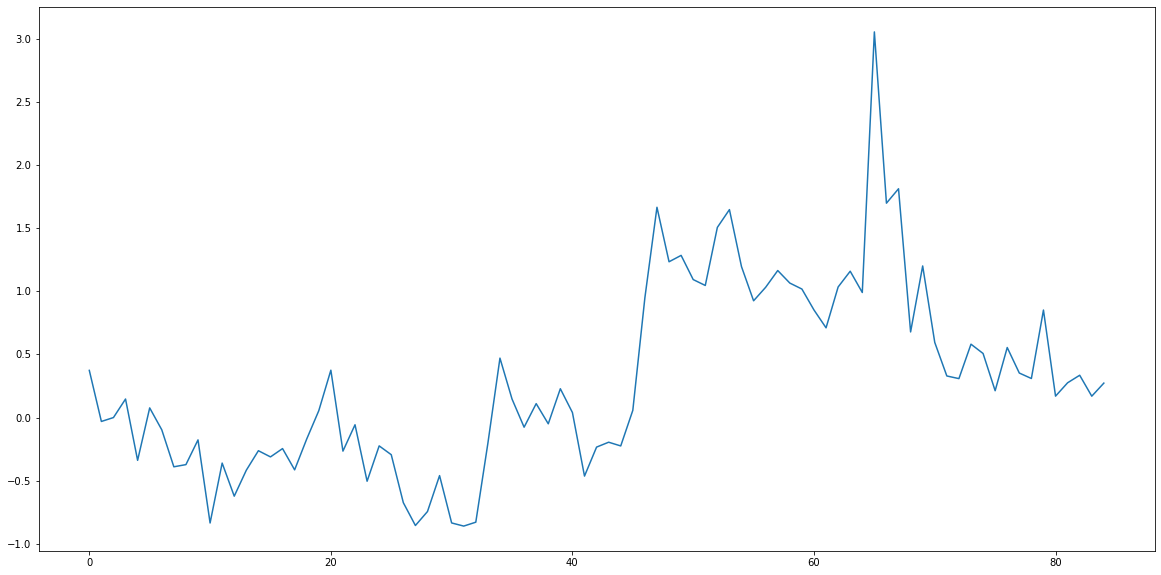

In [75]:
ASJ_data['AccX_avg'].plot(figsize=(20,10))

<AxesSubplot:>

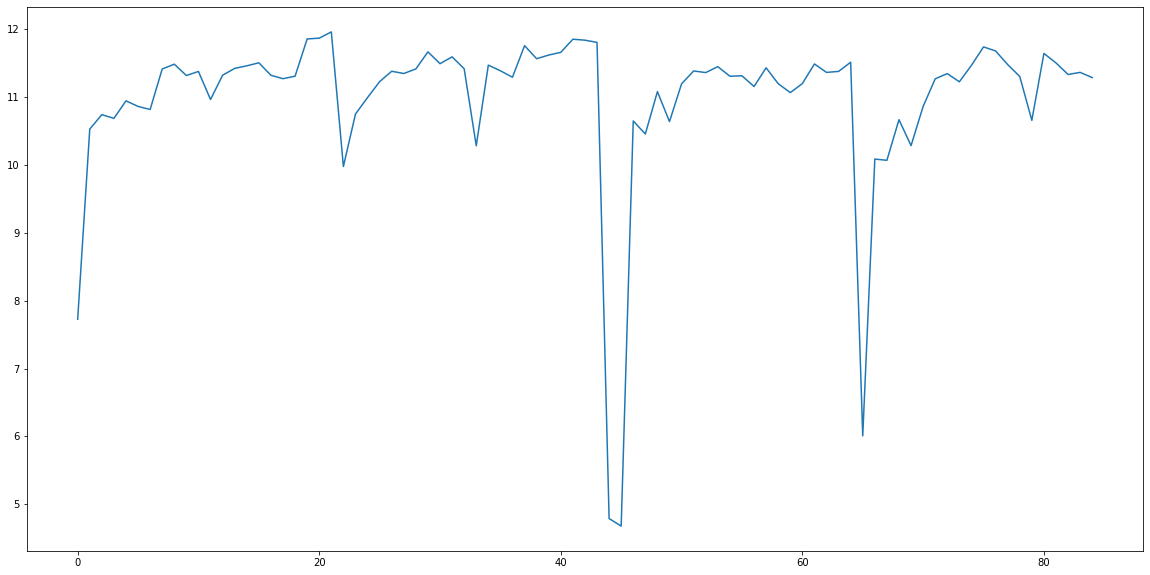

In [76]:
ASJ_data['AccY_avg'].plot(figsize=(20,10))

<AxesSubplot:>

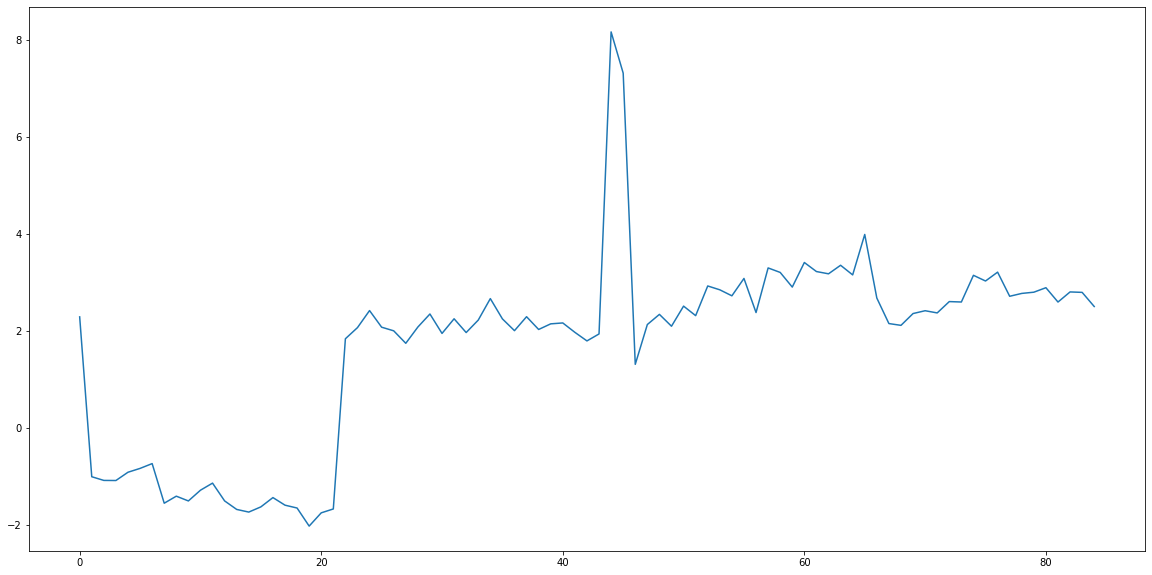

In [77]:
ASJ_data['AccZ_avg'].plot(figsize=(20,10))

<AxesSubplot:>

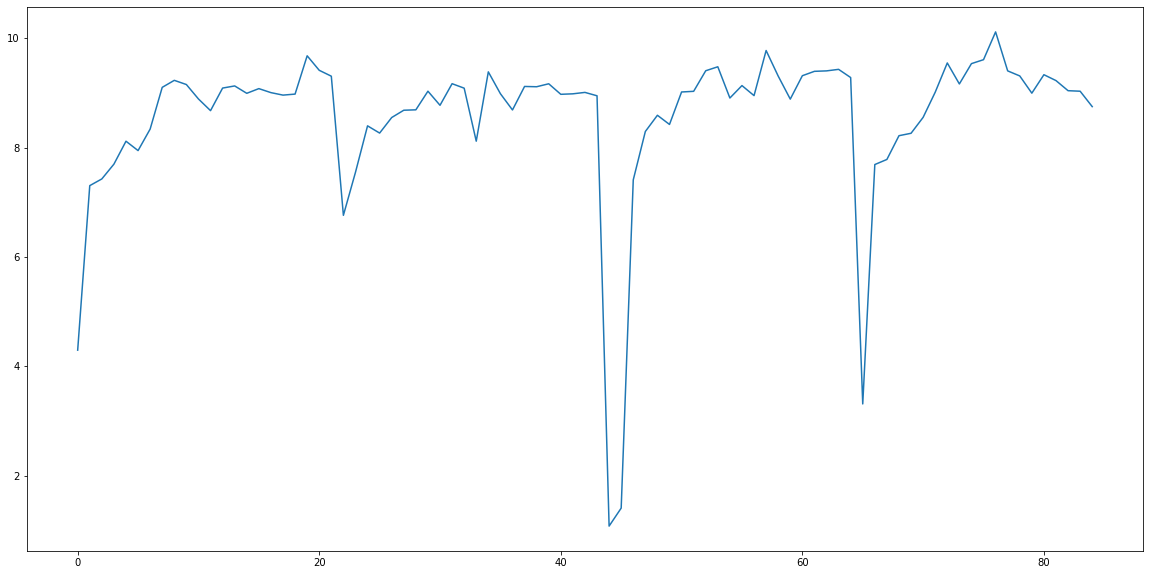

In [78]:
ASJ_data['Linear_avg'].plot(figsize=(20,10))

<AxesSubplot:>

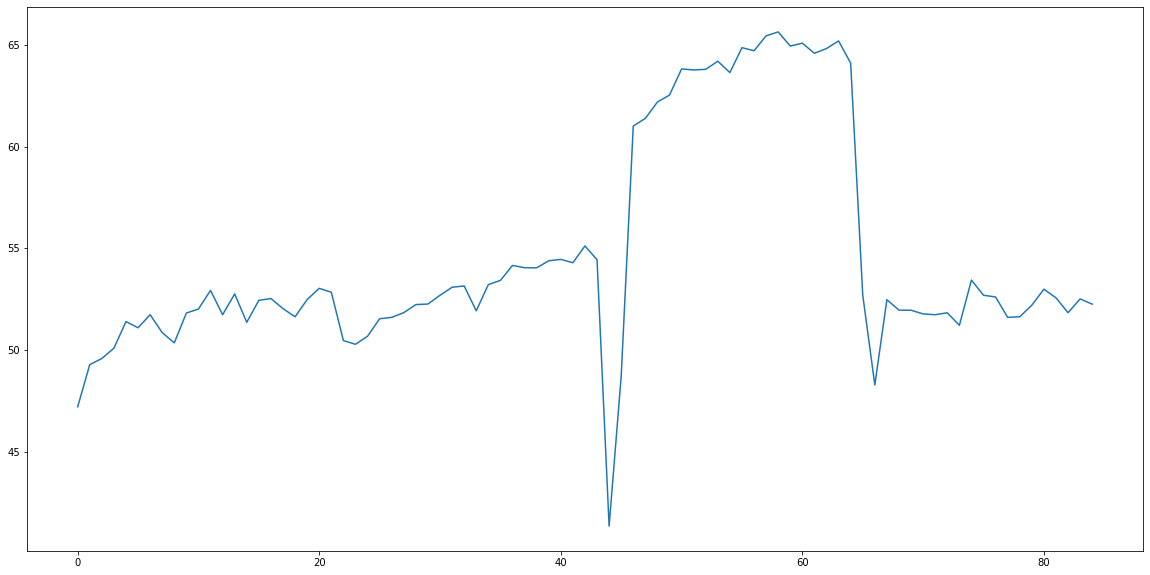

In [79]:
ASJ_data['Decibel_avg'].plot(figsize=(20,10))

### AJ Data Pre-Processing Juan Version

In [7]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re

#### Relevant Parameters of interest (user specific)

In [2]:
data_dir = os.getcwd()+'/Data/Juan/Run/'

test = pd.read_csv(data_dir+'Run_0205.csv')
test['timestamp'] = test.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)

In [3]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [4]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step. 
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    df = data.copy()
    
    if method == 'inference':
        raise ValueError('Method inference from session_start function is still under construction...come back later')
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [5]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None):
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several time series
    into a single one). For this purpose we will simply do individual pre-processing steps on each of the csv files and then
    merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)] 
    full_df = pd.DataFrame()
    
    for session in session_files:
        
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='percentage', value=.02)
        print(re.findall('\d+', session)[0])
        print('Session Start: ' + str(min(df_start['timestamp'])))
        print('Session End: ' + str(max(df_start['timestamp'])))
        print()
        print('Session Length: ' + str(datetime.strptime(max(df_start['timestamp']), "%Y-%m-%d %H:%M:%S.%f")-
                                       datetime.strptime(min(df_start['timestamp']), "%Y-%m-%d %H:%M:%S.%f")))
        print('=================')
        full_df = pd.concat([full_df, df_start])        
        
        
    print('Finished pre-processing individual time series')
    full_df.sort_values(by=['timestamp'], inplace=True)
    
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
        
    return full_df
    

0205
Session Start: 2021-05-02 18:00:16.629
Session End: 2021-05-02 18:06:20.428

Session Length: 0:06:03.799000
0405
Session Start: 2021-05-04 18:58:39.120
Session End: 2021-05-04 19:04:34.166

Session Length: 0:05:55.046000
0705
Session Start: 2021-05-07 18:34:00.739
Session End: 2021-05-07 18:39:30.192

Session Length: 0:05:29.453000
1304
Session Start: 2021-04-13 18:50:38.821
Session End: 2021-04-13 18:54:21.910

Session Length: 0:03:43.089000
1504
Session Start: 2021-04-15 17:24:57.860
Session End: 2021-04-15 17:32:12.599

Session Length: 0:07:14.739000
1604
Session Start: 2021-04-16 19:17:10.348
Session End: 2021-04-16 19:23:54.668

Session Length: 0:06:44.320000
2104
Session Start: 2021-04-21 19:00:43.597
Session End: 2021-04-21 19:09:09.684

Session Length: 0:08:26.087000
2204
Session Start: 2021-04-22 19:14:33.233
Session End: 2021-04-22 19:20:17.773

Session Length: 0:05:44.540000
2404
Session Start: 2021-04-24 19:17:57.120
Session End: 2021-04-24 19:24:35.061

Session Length

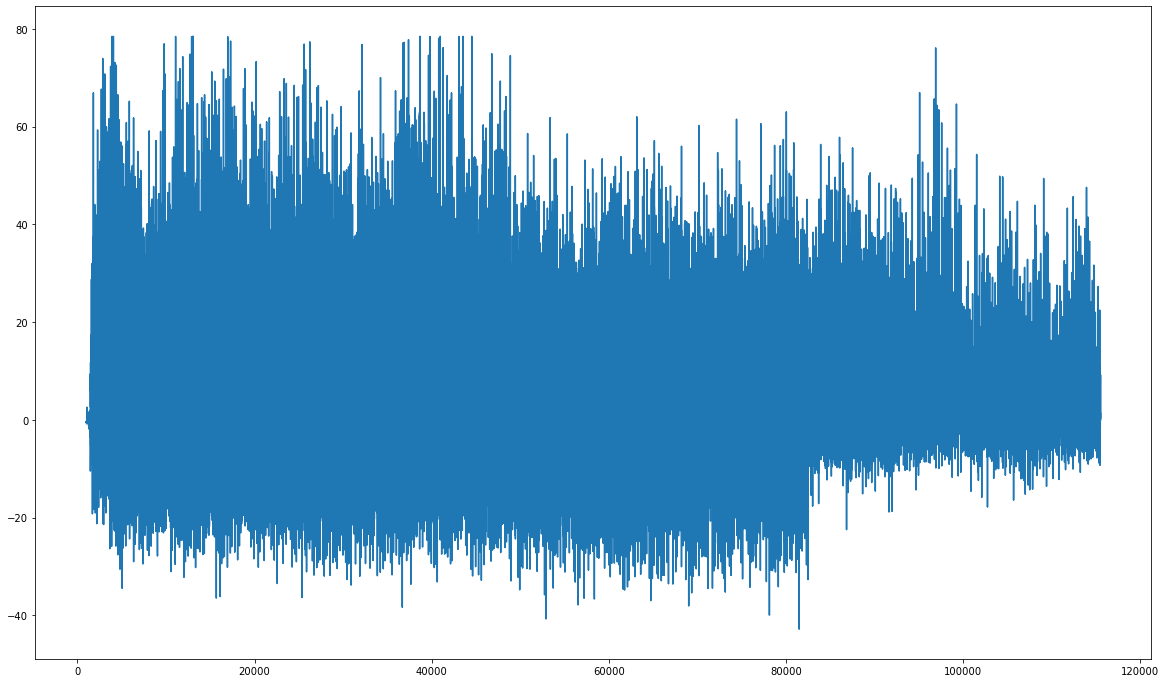

In [8]:
full = generate_full_time_series_AJ('Data/Juan/Run/', plot='AccX')

In [140]:
test.head(50)

,timestamp,AmbientLightSensor,DecibelSource,PitchSensor,LinearAccelerometerSensor,AccX,AccY,AccZ,CompassSensor,MagneticRotationSensor
0,2021-05-02 18:00:09.222,NaN,50.852644,237.802734,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-02 18:00:09.226,NaN,NaN,130.996094,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-02 18:00:09.230,NaN,NaN,NaN,1.286658,0.818405,0.729599,9.997421,238.743775,38.794033
3,2021-05-02 18:00:09.254,NaN,NaN,NaN,NaN,2.572357,0.978455,9.250854,252.124771,38.386735
4,2021-05-02 18:00:09.262,NaN,51.490057,130.996094,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-05-02 18:00:09.273,NaN,NaN,NaN,NaN,2.306747,0.679352,9.717468,241.218024,36.620165
6,2021-05-02 18:00:09.283,NaN,NaN,NaN,NaN,1.282623,0.720016,10.157745,237.837750,38.004247
7,2021-05-02 18:00:09.287,NaN,NaN,NaN,1.974719,NaN,NaN,NaN,NaN,NaN
8,2021-05-02 18:00:09.298,NaN,NaN,NaN,NaN,0.837555,0.827698,10.301315,239.220385,NaN
9,2021-05-02 18:00:09.302,NaN,50.603046,130.996094,NaN,NaN,NaN,NaN,239.962649,38.030030


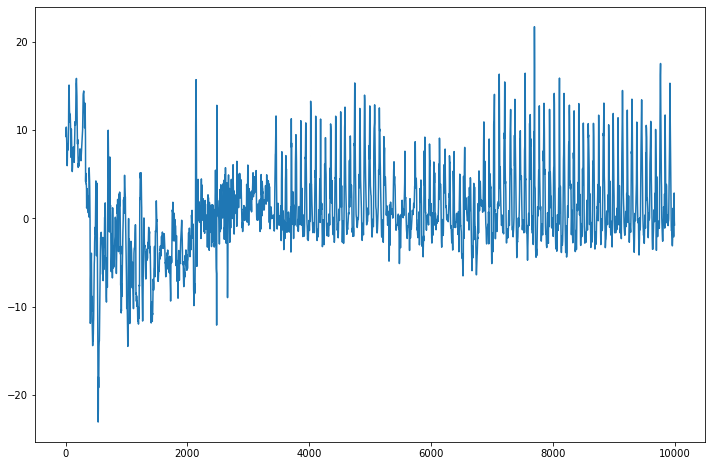

In [14]:
test_miss = missing_data_treatment(test, method='interpolation')
#print(test_miss.head(50))
plt.figure(figsize=(12,8))
plt.plot(test_miss['AccZ'][:10000])